In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [5]:
words = open("/Users/vishwas/Desktop/build_my_web/data/words.txt", "r").readlines()
words_list = []
for line in words:
    if line[0]=='#':
        continue
    if line.split(" ")[1]!="err": # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)
words_list[:5]

['a01-000u-00-00 ok 154 408 768 27 51 AT A\n',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE\n',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to\n',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop\n',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.\n']

In [12]:
np.random.shuffle(words_list)
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
train_samples[7]

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


'e07-101-03-00 ok 152 388 1288 44 56 PP3 it\n'

In [13]:
base_image_path = "/Users/vishwas/Desktop/build_my_web/data/words"
def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        
        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0] 
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path =  os.path.join(base_image_path, partI, 
            partI + "-" + partII,
            image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])
#         print(file_line,"..",image_name,"..",partI,"..",partII,"..",img_path)
#         break
    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)
train_img_paths[7],train_labels[7]

('/Users/vishwas/Desktop/build_my_web/data/words/e07/e07-101/e07-101-03-00.png',
 'e07-101-03-00 ok 152 388 1288 44 56 PP3 it')

In [60]:
def clean_labels(labels,test):
    cleaned_labels = []
    characters=set()
    max_len=0
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
        if(test):
            for char in label:
                characters.add(char)
            max_len = max(max_len,len(label))
     
    if(test):
        return cleaned_labels,characters,max_len
    else:
        return cleaned_labels

train_labels_cleaned,characters,max_len=clean_labels(train_labels,1)
validation_labels_cleaned = clean_labels(validation_labels,0)
test_labels_cleaned = clean_labels(test_labels,0)

In [61]:
print("Maximum length: ", max_len)
print("Vocab size(alpha+num+punch): ", len(characters))
print(len(train_labels_cleaned))
train_labels_cleaned[7]

Maximum length:  21
Vocab size(alpha+num+punch):  78
86808


'it'

In [62]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)
#char_to_num.get_vocabulary()

In [63]:
char_to_num("v i s h w a s a".split(" "))

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([38, 72, 19, 11, 71, 20, 19, 20])>

In [64]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

In [65]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image  = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
                  [pad_height_top, pad_height_bottom],
                  [pad_width_left, pad_width_right],
                  [0, 0]
                ]
        )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    
    return {"image": image, "label": label}

AUTOTUNE = tf.data.AUTOTUNE
def prepare_dataset(image_paths, labels):
    
    #creats a something like generator and applies a funtion for each element (.map)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    #batch is like grouping into buckets
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [101]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

(<tf.Tensor: shape=(21,), dtype=string, numpy=
 array([b'a', b's', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]'], dtype=object)>,
 21,
 'as[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]')

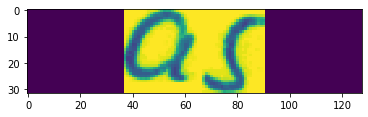

In [124]:
x=process_images_labels(train_img_paths[10], train_labels_cleaned[10])
img=x["image"]
img = tf.image.flip_left_right(img)
img = tf.transpose(img, perm=[1, 0, 2])
img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
img = img[:, :, 0]
plt.imshow(img)
num_to_char(x["label"]),max_len,tf.strings.reduce_join(num_to_char(x["label"])).numpy().decode("utf-8")

In [125]:
#Creates a Dataset with at most count elements from this dataset. - 
#take(1) takes first data/bucket from dataset
#take(5) takes first 5 datas/buckets from dataset
train_ds.take(1)

<TakeDataset shapes: {image: (None, None, None, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>

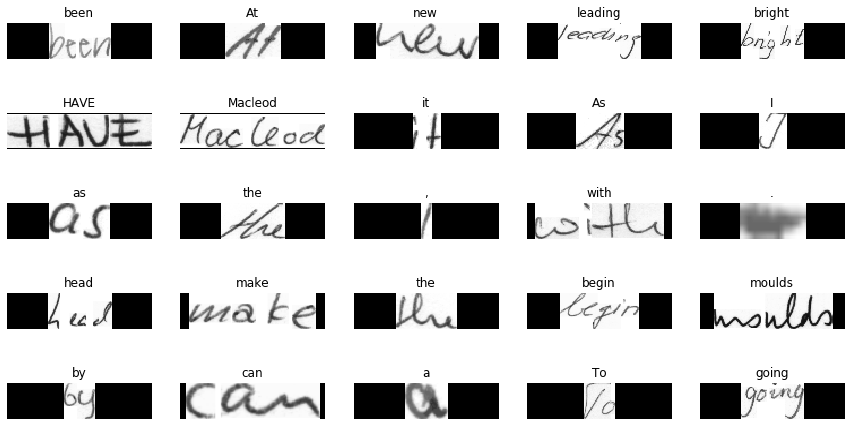

In [126]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(5, 5, figsize=(15, 8))

    for i in range(25):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= 99.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 5, i % 5].imshow(img, cmap="gray")
        ax[i // 5, i % 5].set_title(label)
        ax[i // 5, i % 5].axis("off")


plt.show()